In [1]:
import sys
sys.path.insert(0, '../')
import torch
from models.custom import HorizonModel

model = HorizonModel('../yolos/yolov5n6_RGB_D2304-v1_9C.pt')
[print(m.i, m.f, m.type) for m in model.model]
model.info()

pred = model(torch.zeros(1, 3, 640, 640).to(model.device))
assert pred[0].shape == (1, 500) and pred[1].shape == (1, 500)

YOLOv5 🚀 v7.0-24-g22e72e2 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)

Loaded weights from ../yolos/yolov5n6_RGB_D2304-v1_9C.pt
WARNING ⚠️ converting YOLOv5 DetectionModel to HorizonModel


0 -1 models.common.Conv
1 -1 models.common.Conv
2 -1 models.common.C3
3 -1 models.common.Conv
4 -1 models.common.C3
5 -1 models.common.Conv
6 -1 models.common.C3
7 -1 models.common.Conv
8 -1 models.common.C3
9 -1 models.common.Conv
10 -1 models.common.C3
c_pitch 10 models.common.Classify
c_theta 10 models.common.Classify


Model summary: 147 layers, 3359304 parameters, 1941480 gradients, 4.7 GFLOPs


In [3]:
ckpt = {
    'epoch': 1,
    'best_fitness': 0,
    'model': model,  # deepcopy(de_parallel(model)).half(),
    'ema': None,  # deepcopy(ema.ema).half(),
    'updates': None,
    'optimizer': None,  # optimizer.state_dict(),
    'opt': None,
    'date': None
    }

# Save last, best and delete
torch.save(ckpt, 'ckpt.pt')

In [4]:
model = HorizonModel('ckpt.pt', device='1')
[print(m.i, m.f, m.type) for m in model.model]
model.info()

pred = model(torch.zeros(1, 3, 640, 640).to(model.device))
assert pred[0].shape == (1, 500) and pred[1].shape == (1, 500)

YOLOv5 🚀 v7.0-15-ge8b349c Python-3.10.11 torch-2.0.1 CUDA:1 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)



Model summary: 126 layers, 2823240 parameters, 1941480 gradients, 4.3 GFLOPs


0 -1 models.common.Conv
1 -1 models.common.Conv
2 -1 models.common.C3
3 -1 models.common.Conv
4 -1 models.common.C3
5 -1 models.common.Conv
6 -1 models.common.C3
7 -1 models.common.Conv
8 -1 models.common.C3
c_pitch 8 models.common.Classify
c_theta 8 models.common.Classify


In [2]:
import sys
sys.path.insert(0, '../')

import numpy as np
import fiftyone as fo
from fiftyone import ViewField as F
import torch
from PIL import Image

from utils.horizon import draw_horizon
from models.custom import HorizonModel
from horizon.dataloaders import (get_train_rgb_dataloader,
                                 get_val_rgb_dataloader,
                                 get_train_IR16bit_dataseloader,
                                 get_val_IR16bit_dataloader)

dataset_name = "TRAIN_THERMAL_DATASET_2023_06_16bit"
train_tag, val_tag = "TRAIN_v0", "VAL_v0"
imgsz = 640

dataset_name = "SAILING_DATASET_RGB_2023_10"
train_tag, val_tag = "TRAIN_v0", "VAL_v0"
imgsz = 1280

weights = f'../runs/horizon/train/{dataset_name}/best.pt'
model = HorizonModel(weights, device='0')

if "RGB" in dataset_name:
    dataloader = get_val_rgb_dataloader(
        dataset=(fo.load_dataset(dataset_name)
                .match(F("ground_truth_pl.polylines.closed") == [False])
                .match_tags(val_tag)
                #.match(F("trip") == "Trip_306")
                #.take(5000, seed=51)
                ),
        imgsz=imgsz,
        batch_size=1,
        num_workers=0,
        shuffle=True,
    )
else:
    dataloader = get_val_IR16bit_dataloader(
        dataset=(fo.load_dataset(dataset_name)
                .match(F("ground_truth_pl.polylines.closed") == [False])
                .match_tags(val_tag)
                ),
        imgsz=imgsz,
        batch_size=1,
        num_workers=0,
        shuffle=True,
    )

YOLOv5 🚀 v7.0-24-g22e72e2 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)

Loaded weights from ../runs/horizon/train/SAILING_DATASET_RGB_2023_10/best.pt


Migrating dataset 'SAILING_DATASET_RGB_2023_10' to v0.23.0


target=	tensor([[0.54454, 0.48578]], dtype=torch.float64)
pred=	tensor([[0.43000, 0.48400]])
pred=	tensor([[0.43267, 0.48492]], dtype=torch.float64)


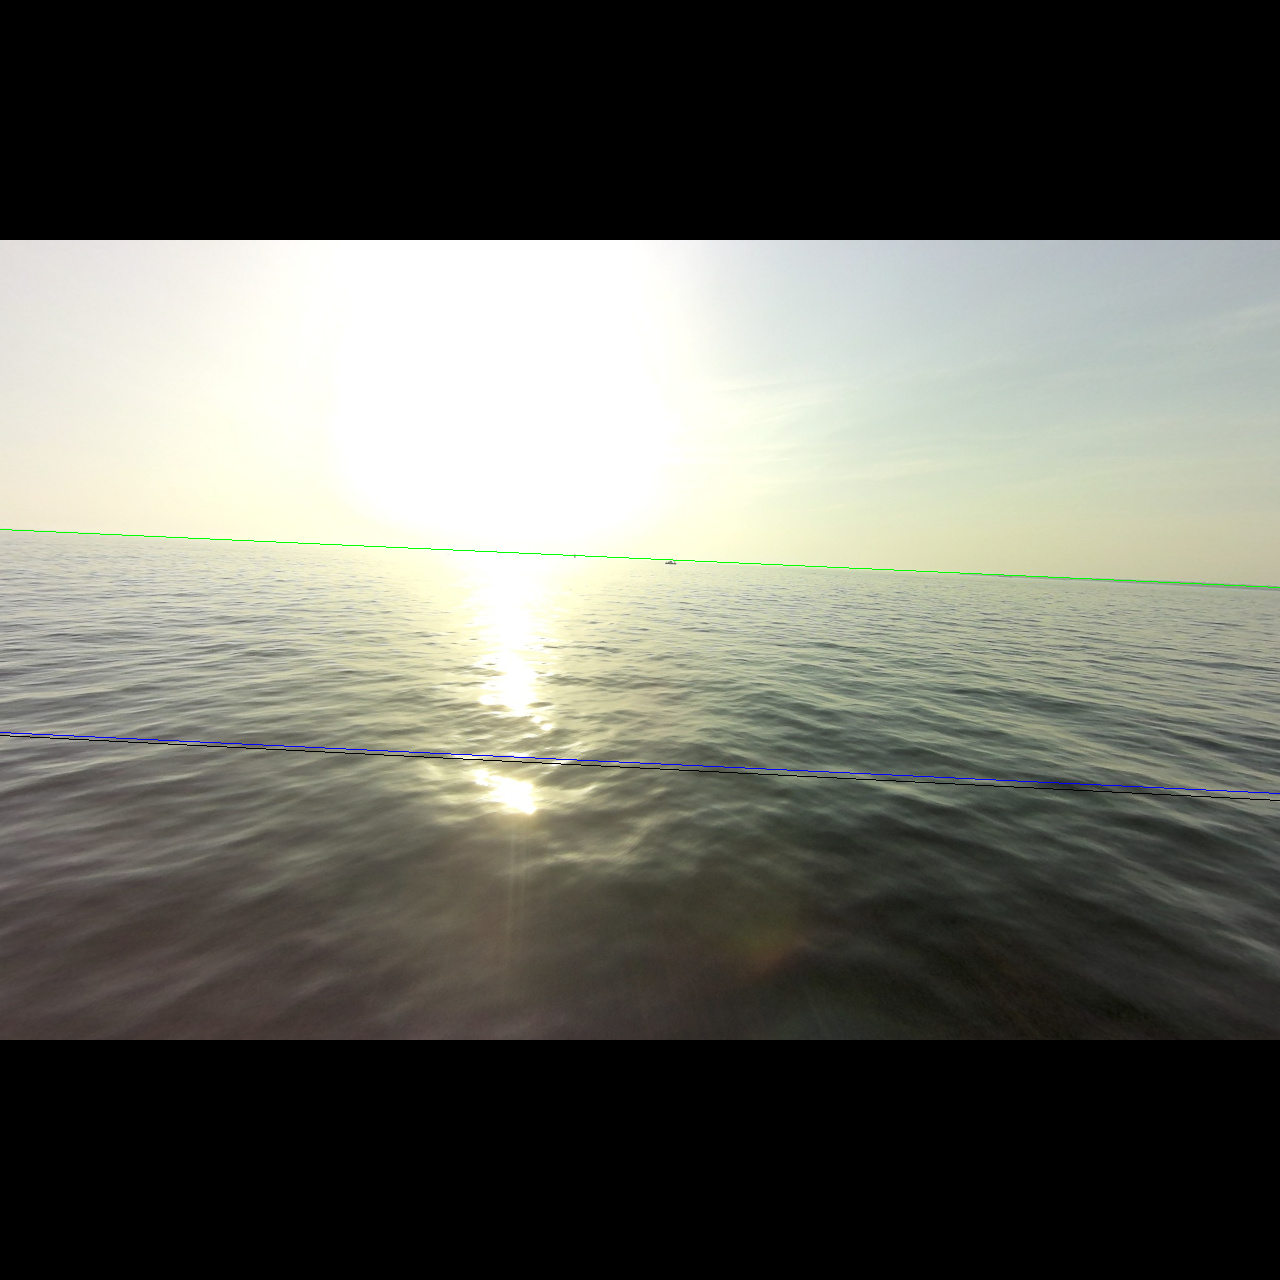

In [3]:
import pandas as pd
from scipy.optimize import curve_fit
import plotly.express as px
import plotly.graph_objects as go

for image, target in dataloader:
   break

def postprocess_x_pitch_theta(x_pitch, x_theta):
    def my_linspace(start, stop, num, device):
        # fake endpoint=False
        return torch.linspace(start, stop, num+1, device=device)[:-1]
    
    x_pitch, x_theta = x_pitch.softmax(1), x_theta.softmax(1)
    _, pitch = x_pitch.max(1, keepdim=True)
    pitch = pitch / x_pitch.shape[-1]
    _, theta = x_theta.max(1, keepdim=True)
    theta = theta / x_theta.shape[-1]

    return pitch, theta

with torch.no_grad():
    x_pitch, x_theta = model(image.to(model.device))
    pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)
    pitch, theta = pitch.detach().cpu(), theta.detach().cpu()

x_pitch, x_theta = x_pitch.softmax(1), x_theta.softmax(1)
x_pitch = x_pitch.squeeze().cpu().numpy()
x_theta = x_theta.squeeze().cpu().numpy()
x = np.linspace(0, 1, len(x_pitch), endpoint=False)

# curve fitting
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Initial guess for the parameters (amplitude, mean, standard deviation)
initial_pitch_guess = [x_pitch.max(), x_pitch.argmax() / x_pitch.shape[-1], 0.001]
initial_theta_guess = [x_theta.max(), x_theta.argmax() / x_theta.shape[-1], 0.001]

x_data = np.linspace(0, 1, x_pitch.shape[0], endpoint=False)
params_pitch, cov_pitch = curve_fit(gaussian, x_data, x_pitch, p0=initial_pitch_guess)
params_theta, cov_theta = curve_fit(gaussian, x_data, x_theta, p0=initial_theta_guess)

# print
print(f"target=\t{target}")
print(f"pred=\t{torch.cat((pitch, theta), 1)}")
print(f"pred=\t{torch.tensor([[params_pitch[1], params_theta[1]]])}")

# plotting
x_data = np.linspace(0, 1, 5000, endpoint=False)
df_gauss = pd.DataFrame({"x_gauss": x_data,
                         "pitch_gauss": gaussian(x_data, *params_pitch),
                         "theta_gauss": gaussian(x_data, *params_theta)}
                        )
fig = px.line(df_gauss, x="x_gauss", y=["pitch_gauss", "theta_gauss"])
fig.add_bar(x=x, y=x_pitch, name="pitch", marker=dict(color="blue", opacity=0.5))
fig.add_bar(x=x, y=x_theta, name="theta", marker=dict(color="red", opacity=0.5))
fig.update_layout(barmode='overlay', title=f"{params_pitch=}, {params_theta=}")
fig.show()

I = (image[0].permute(1,2,0) * 255).numpy().astype(np.uint8)
diameter = 1
I = draw_horizon(I, pitch_theta=(target[0][0], target[0][1]), color=(0,255,0), diameter=diameter)
I = draw_horizon(I, pitch_theta=(pitch[0][0], theta[0][0]), color=(0,0,0), diameter=diameter)
I = draw_horizon(I, pitch_theta=(params_pitch[1], params_theta[1]), color=(0,0,255), diameter=diameter)
I = Image.fromarray(I)
I #.reduce(2) if I.width >= 1024 else I

In [1]:
import sys
sys.path.insert(0, '../')

import fiftyone as fo
from fiftyone import ViewField as F

from models.custom import AHOY
from horizon.dataloaders import get_val_rgb_dataloader

dataset_name = "SAILING_DATASET_RGB_2023_10"
train_tag, val_tag = "TRAIN_v0", "VAL_v0"
imgsz = 1280

dataloader = get_val_rgb_dataloader(
        dataset=(fo.load_dataset(dataset_name)
                .match(F("ground_truth_pl.polylines.closed") == [False])
                .match_tags(val_tag)
                #.match(F("trip") == "Trip_306")
                #.take(5000, seed=51)
                ),
        imgsz=imgsz,
        batch_size=1,
        num_workers=0,
        shuffle=True,
    )

detector_weigths = "../yolos/yolov5n6_RGB_D2304-v1_9C.pt"
horizon_weights = "../runs/horizon/train/SAILING_DATASET_RGB_2023_10-1280/best.pt"
ahoy = AHOY(detector_weigths, horizon_weights, fp16=True)

YOLOv5 🚀 v7.0-24-g22e72e2 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)

Fusing layers... 
Model summary: 206 layers, 3102712 parameters, 0 gradients, 4.3 GFLOPs
Loaded weights from ../yolos/yolov5n6_RGB_D2304-v1_9C.pt
YOLOv5 🚀 v7.0-24-g22e72e2 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)

Fusing layers... 
Model summary: 108 layers, 3353720 parameters, 0 gradients, 4.6 GFLOPs
Loaded weights from ../runs/horizon/train/SAILING_DATASET_RGB_2023_10-1280/best.pt
YOLOv5 🚀 v7.0-24-g22e72e2 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)



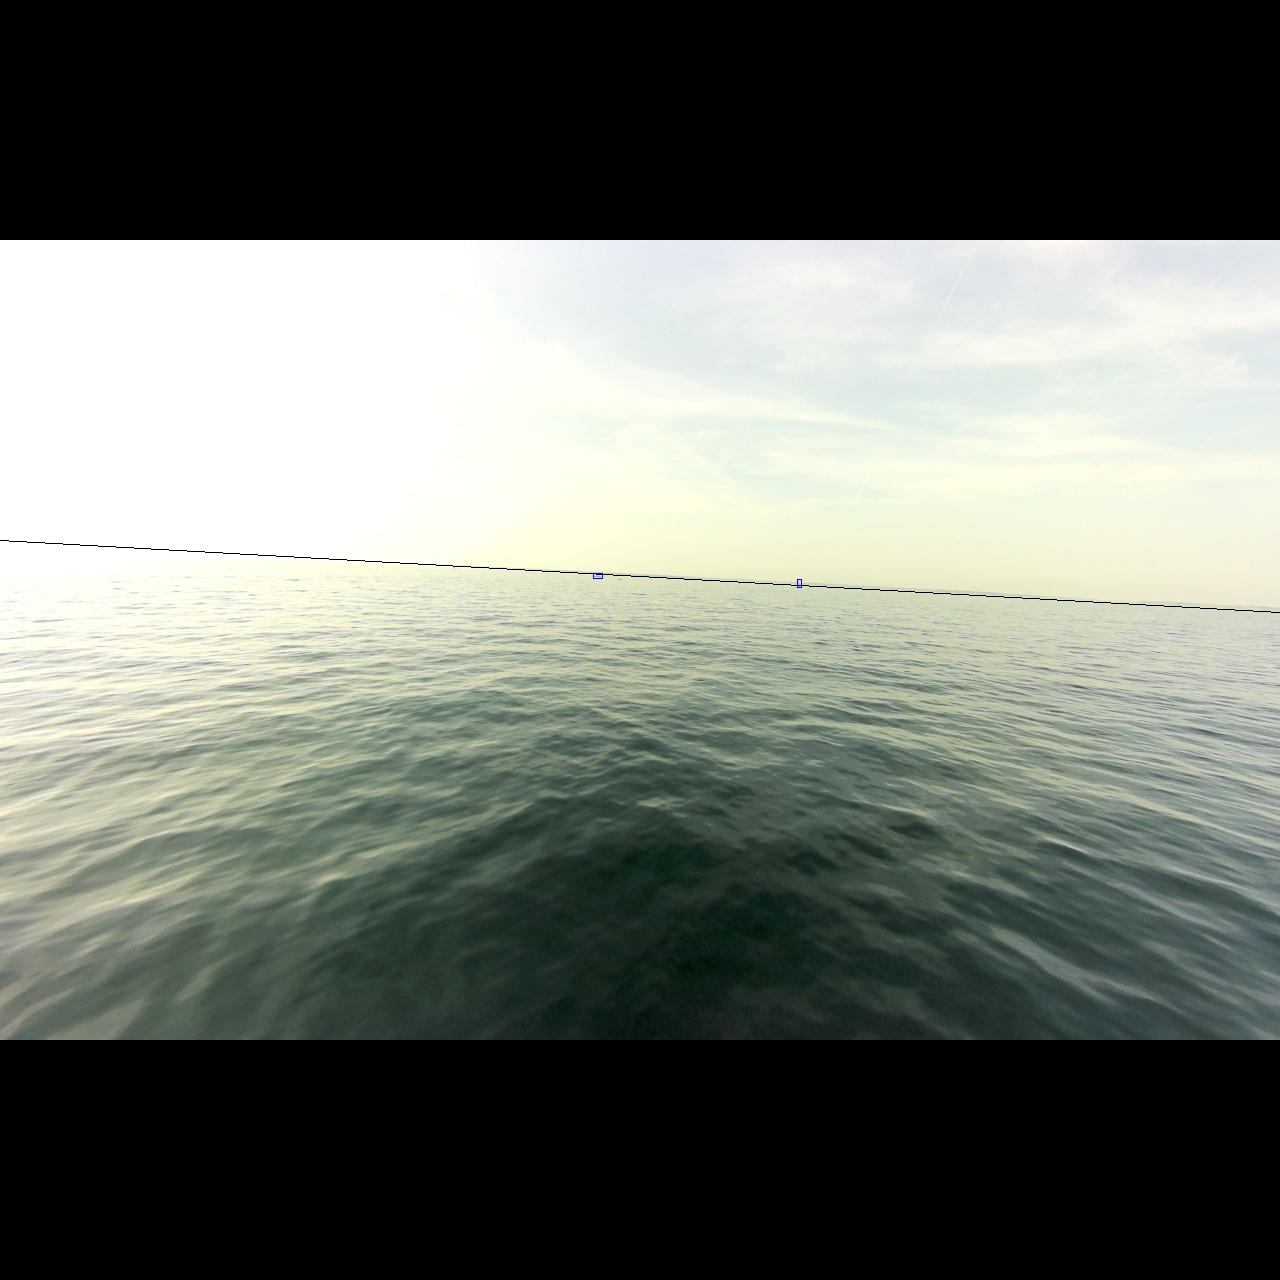

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from PIL import Image

import torch

import plotly.express as px
import plotly.graph_objects as go

from utils.general import non_max_suppression
from utils.horizon import draw_horizon, draw_bboxes

for image, target in dataloader:
   break

def postprocess_x_pitch_theta(x_pitch, x_theta):
    # curve fitting
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

    x_pitch = x_pitch.squeeze().cpu().numpy()
    x_theta = x_theta.squeeze().cpu().numpy()

    # Initial guess for the parameters (amplitude, mean, standard deviation)
    pitch0 = [x_pitch.max(), x_pitch.argmax() / x_pitch.shape[-1], 0.001]
    theta0 = [x_theta.max(), x_theta.argmax() / x_theta.shape[-1], 0.001]

    x_data = np.linspace(0, 1, x_pitch.shape[0], endpoint=False)
    params_pitch, cov_pitch = curve_fit(gaussian, x_data, x_pitch, p0=pitch0)
    params_theta, cov_theta = curve_fit(gaussian, x_data, x_theta, p0=theta0)

    return params_pitch[1], params_theta[1]

def postprocess_dets(
        dets,
        conf_thres=0.25,
        iou_thres=0.1,
        classes=None,
        agnostic_nms=True,
        max_det=100
):           
    dets = non_max_suppression(dets, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    return dets[0].cpu().numpy()

with torch.no_grad():
    x = image.to(ahoy.device)
    x = x.half() if ahoy.fp16 else x.float()
    dets, x_pitch, x_theta = ahoy(x)
    dets = postprocess_dets(dets)
    pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)


I = (image[0].permute(1,2,0) * 255).numpy().astype(np.uint8)
diameter = 1
I = draw_bboxes(I, dets, color=(0,0,255), thickness=1)
# I = draw_horizon(I, pitch_theta=(target[0][0], target[0][1]), color=(0,255,0), diameter=diameter)
I = draw_horizon(I, pitch_theta=(pitch, theta), color=(0,0,0), diameter=diameter)
I = Image.fromarray(I)
I #.reduce(2) if I.width >= 1024 else I

In [4]:
from pathlib import Path
from export import export_engine
from models.yolo import Detect

inplace = False # default
dynamic = False # default

# Update model
ahoy.eval()
for k, m in ahoy.named_modules():
    if isinstance(m, Detect):
        m.inplace = inplace
        m.dynamic = dynamic
        m.export = True


export_engine(
    ahoy,
    im=image.to(ahoy.device).half() if ahoy.fp16 else image.to(ahoy.device).float(),
    file=Path("ahoy.engine"),
    half=ahoy.fp16,
    #opset=12,
    dynamic=dynamic,
    simplify=False,
)


ONNX: starting export with onnx 1.13.1...
/home/kevinserrano/GitHub/yolov5/horizon/../models/yolo.py:119: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if profile:
/home/kevinserrano/GitHub/yolov5/horizon/../models/yolo.py:123: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if visualize:
/home/kevinserrano/GitHub/yolov5/horizon/../models/yolo.py:123: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This

[12/24/2023-12:45:14] [TRT] [I] [MemUsageChange] Init CUDA: CPU +459, GPU +0, now: CPU 3865, GPU 1344 (MiB)
[12/24/2023-12:45:19] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +885, GPU +172, now: CPU 4826, GPU 1516 (MiB)
[12/24/2023-12:45:19] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[12/24/2023-12:45:19] [TRT] [I] ----------------------------------------------------------------
[12/24/2023-12:45:19] [TRT] [I] Input filename:   ahoy.onnx
[12/24/2023-12:45:19] [TRT] [I] ONNX IR version:  0.0.7
[12/24/2023-12:45:19] [TRT] [I] Opset version:    12
[12/24/2023-12:45:19] [TRT] [I] Producer name:    pytorch
[12/24/2023-12:45:19] [TRT] [I] Producer version: 2.1.0
[12/24/2023-12:45:19] [TRT] [I] Domain:           
[12/24/2023-12:45:19] [TRT] [I] Model version

TensorRT: export success ✅ 462.2s, saved as ahoy.engine (16.5 MB)


[12/24/2023-12:52:55] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in building engine: CPU +2, GPU +16, now: CPU 2, GPU 16 (MiB)


(PosixPath('ahoy.engine'), None)

In [6]:
! ls -lh

total 37M
-rw-rw-r-- 1 kevinserrano kevinserrano  17M Dez 24 12:52 ahoy.engine
-rw-rw-r-- 1 kevinserrano kevinserrano  14M Dez 24 12:45 ahoy.onnx
-rw-rw-r-- 1 kevinserrano kevinserrano 7,3K Nov  6 17:23 dataloaders.py
-rw-rw-r-- 1 kevinserrano kevinserrano  14K Dez 24 12:11 models.py
-rw-rw-r-- 1 kevinserrano kevinserrano 524K Okt 19 01:56 playground.ipynb
drwxrwxr-x 2 kevinserrano kevinserrano 4,0K Dez 24 12:11 __pycache__
-rw-rw-r-- 1 kevinserrano kevinserrano 2,0K Okt 23 09:24 README.md
-rw-rw-r-- 1 kevinserrano kevinserrano 6,4M Dez 24 12:43 tests.ipynb
-rw-rw-r-- 1 kevinserrano kevinserrano  11K Dez 23 19:08 train.py
-rw-rw-r-- 1 kevinserrano kevinserrano 5,4K Nov 10 16:27 transforms.py
-rw-rw-r-- 1 kevinserrano kevinserrano 5,7K Dez 23 20:01 utils.py
